In [ ]:
!pip install -q torch torchvision tqdm matplotlib ptflops



In [ ]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from typing import List, Tuple
import time
from ptflops import get_model_complexity_info
import torch.optim as optim
from torchvision.datasets import CIFAR10

In [ ]:
# ----- D4 transforms on a 2D numpy array (kernel) -----
def d4_transforms(kernel: np.ndarray) -> List[np.ndarray]:
    # kernel shape: (H, W)
    # return list of the 7 non-identity D4 transforms in consistent order:
    # rotations r (90), r2 (180), r3 (270), reflect vertical (s),
    # reflect diag top-left->bottom-right (sr), reflect horizontal (sr2),
    # reflect diag top-right->bottom-left (sr3)
    t = []
    t.append(np.rot90(kernel, k=1))   # r
    t.append(np.rot90(kernel, k=2))   # r2
    t.append(np.rot90(kernel, k=3))   # r3
    t.append(np.fliplr(kernel))       # s (vertical)
    # diagonal reflect top-left to bottom-right -> transpose
    t.append(kernel.T)                # sr
    t.append(np.flipud(kernel))       # sr2 (horizontal)
    # diagonal reflect top-right to bottom-left -> transpose then fliplr
    t.append(np.fliplr(kernel.T))     # sr3
    return t

# ----- symmetry metric from paper (Eq.1) -----
def symmetry_score(kernel: np.ndarray) -> float:
    # kernel: 2D array
    # normalize by Frobenius norm (||K||_F)
    norm = np.linalg.norm(kernel)
    if norm == 0:
        return 1.0
    Khat = kernel / norm
    transforms = d4_transforms(Khat)
    # compute average Frobenius distance over the transformations (|T|=7)
    distances = [np.linalg.norm(T - Khat) for T in transforms]
    avg = sum(distances) / len(transforms)
    # paper uses S = 1 - (1/(2*|T|)) * sum ||T(Khat)-Khat||_F
    S = 1.0 - (1.0 / (2.0 * len(transforms))) * sum(distances)
    # clip to [0,1] for safety
    return float(max(0.0, min(1.0, S)))


In [ ]:
# Colab cell (code)
def get_conv_layers(model: torch.nn.Module):
    # returns list of (name, module) for conv layers
    convs = []
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            convs.append((name, module))
    return convs

def mean_kernel_from_conv(conv_module: torch.nn.Conv2d) -> np.ndarray:
    # get weight tensor (out, in, H, W)
    w = conv_module.weight.detach().cpu().numpy()
    # mean over out and in dims -> H x W
    mean_k = w.mean(axis=(0,1))
    return mean_k

def model_mean_kernels(model: torch.nn.Module) -> List[Tuple[str, np.ndarray]]:
    convs = get_conv_layers(model)
    return [(name, mean_kernel_from_conv(mod)) for name, mod in convs]


In [ ]:
# Colab cell (code)
def symmetry_profile(model: torch.nn.Module):
    layers = model_mean_kernels(model)
    names = []
    kernels = []
    scores = []
    for name, k in layers:
        names.append(name)
        kernels.append(k)
        scores.append(symmetry_score(k))
    return names, kernels, scores


In [ ]:
# Colab cell (code)
def show_kernel(kernel: np.ndarray, title=""):
    plt.figure(figsize=(3,3))
    plt.imshow(kernel, cmap='bwr', interpolation='nearest')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.title(title)
    plt.axis('off')
    plt.show()

def plot_symmetry_bar(names, scores, top_n=40):
    # plot bar chart
    x = list(range(len(scores)))[:top_n]
    plt.figure(figsize=(10,4))
    plt.bar(x, scores[:top_n])
    plt.ylim(0,1.0)
    plt.xlabel('Conv layer index')
    plt.ylabel('Symmetry score')
    plt.title('Per-layer symmetry profile (first {} layers shown)'.format(min(top_n, len(scores))))
    plt.show()


Device: cuda


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:05<00:00, 92.4MB/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 187MB/s]


VGG16 conv layers: 13


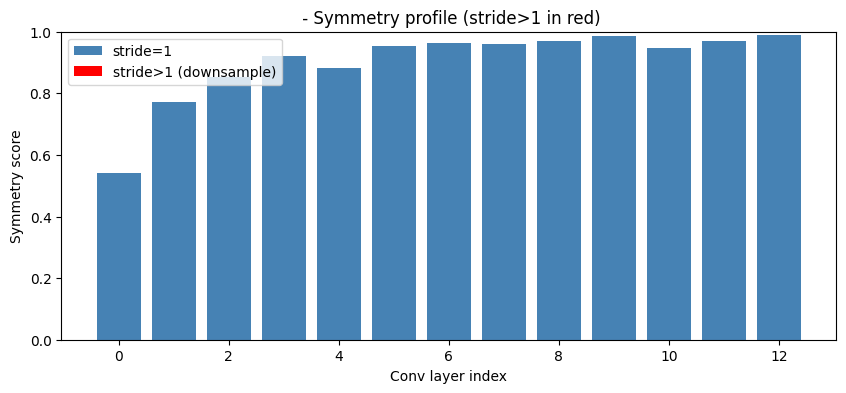

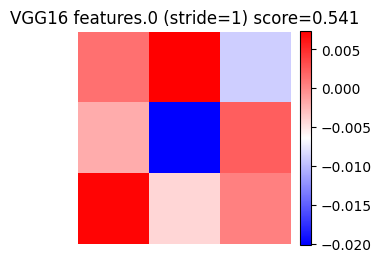

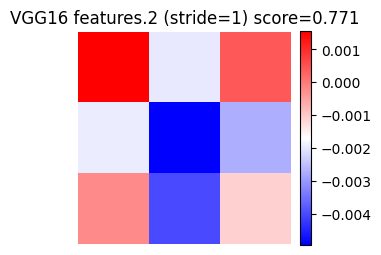

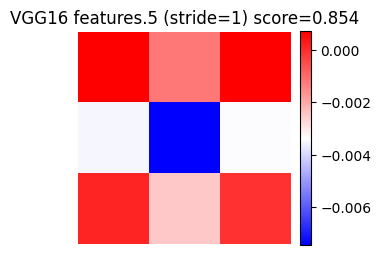

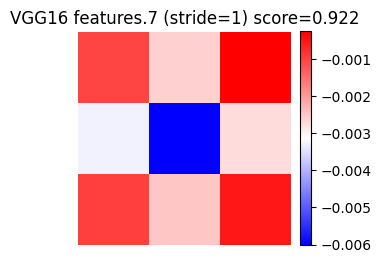

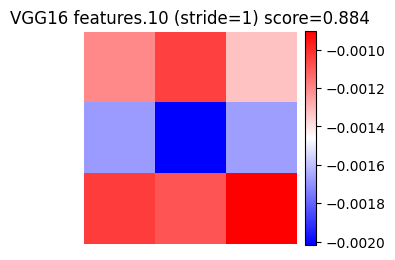

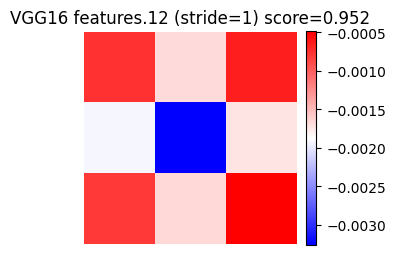

ResNet18 conv layers: 20


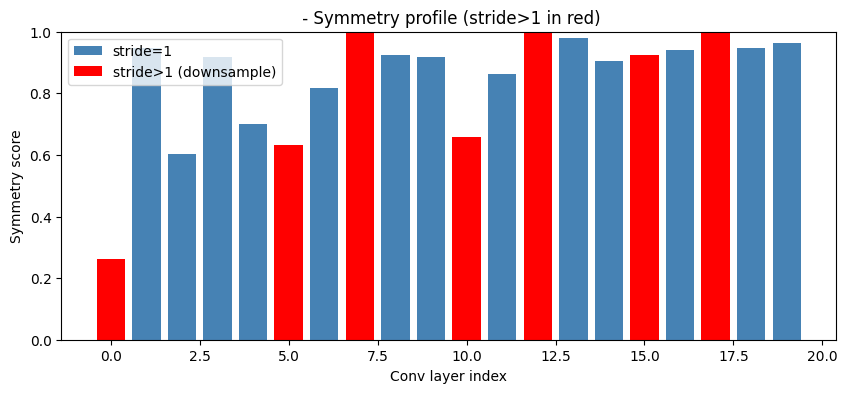

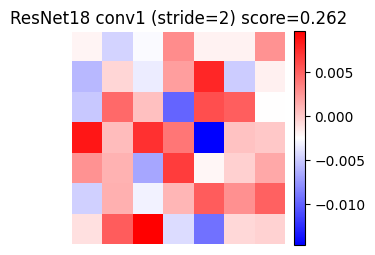

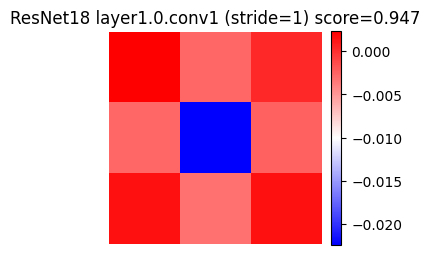

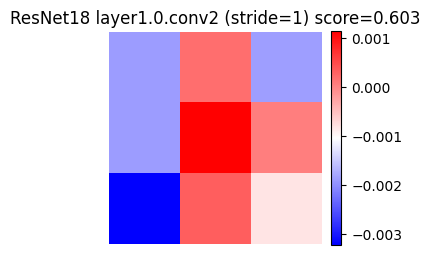

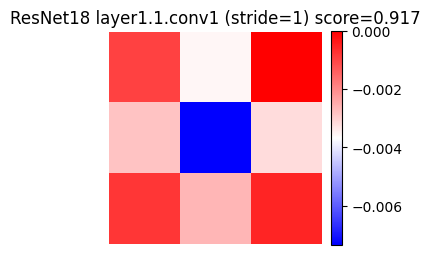

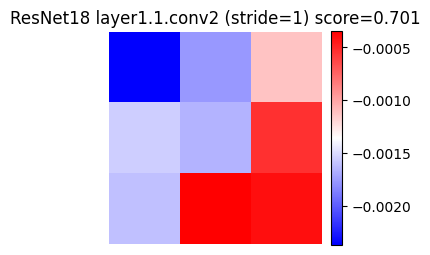

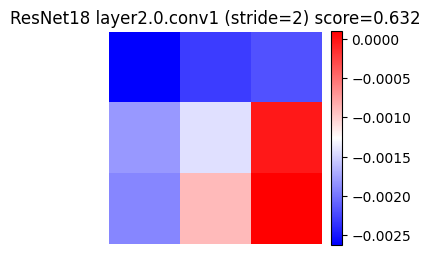

In [ ]:
# Colab cell (code)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---------- stride-aware symmetry profile ----------
def symmetry_profile_with_stride(model: torch.nn.Module):
    convs = get_conv_layers(model)
    names, kernels, scores, strides = [], [], [], []
    for name, conv in convs:
        mean_k = mean_kernel_from_conv(conv)
        names.append(name)
        kernels.append(mean_k)
        scores.append(symmetry_score(mean_k))
        stride_val = conv.stride[0] if isinstance(conv.stride, tuple) else conv.stride
        strides.append(stride_val)
    return names, kernels, scores, strides

# ---------- bar-plot function ----------
def plot_symmetry_bar_with_stride(names, scores, strides, model_name="", top_n=40):
    x = np.arange(len(scores))[:top_n]
    colors = ["red" if strides[i] > 1 else "steelblue" for i in x]
    plt.figure(figsize=(10,4))
    plt.bar(x, scores[:top_n], color=colors)
    plt.ylim(0, 1.0)
    plt.xlabel('Conv layer index')
    plt.ylabel('Symmetry score')
    plt.title(f'{model_name} - Symmetry profile (stride>1 in red)')
    plt.bar(0, 0, color='steelblue', label='stride=1')
    plt.bar(0, 0, color='red', label='stride>1 (downsample)')
    plt.legend()
    plt.show()


# ---------- Run for pretrained models ----------
import torchvision.models as models

vgg16 = models.vgg16(pretrained=True).to(device).eval()
resnet18 = models.resnet18(pretrained=True).to(device).eval()

# ---- VGG16 ----
names_vgg, kernels_vgg, scores_vgg, strides_vgg = symmetry_profile_with_stride(vgg16)
print("VGG16 conv layers:", len(names_vgg))
plot_symmetry_bar_with_stride(names_vgg, scores_vgg, strides_vgg, top_n=40)

for i in range(0, min(6, len(kernels_vgg))):
    show_kernel(kernels_vgg[i], title=f"VGG16 {names_vgg[i]} (stride={strides_vgg[i]}) score={scores_vgg[i]:.3f}")

# ---- ResNet18 ----
names_rn, kernels_rn, scores_rn, strides_rn = symmetry_profile_with_stride(resnet18)
print("ResNet18 conv layers:", len(names_rn))
plot_symmetry_bar_with_stride(names_rn, scores_rn, strides_rn, top_n=40)

for i in range(0, min(6, len(kernels_rn))):
    show_kernel(kernels_rn[i], title=f"ResNet18 {names_rn[i]} (stride={strides_rn[i]}) score={scores_rn[i]:.3f}")


In [ ]:
import matplotlib.pyplot as plt

# ---- VGG16 Mean Kernel Grid ----
fig, axes = plt.subplots(2, 3, figsize=(9, 6))
for i, ax in enumerate(axes.flat):
    if i < len(kernels_vgg):
        ax.imshow(kernels_vgg[i], cmap='bwr', interpolation='nearest')
        ax.set_title(f"{names_vgg[i]}\nS={scores_vgg[i]:.3f}", fontsize=9)
        ax.axis('off')
plt.tight_layout()
plt.savefig("vgg_kernels_grid.png", dpi=300, bbox_inches='tight')

# ---- ResNet18 Mean Kernel Grid ----
fig, axes = plt.subplots(2, 3, figsize=(9, 6))
for i, ax in enumerate(axes.flat):
    if i < len(kernels_rn):
        ax.imshow(kernels_rn[i], cmap='bwr', interpolation='nearest')
        ax.set_title(f"{names_rn[i]}\nS={scores_rn[i]:.3f}", fontsize=9)
        ax.axis('off')
plt.tight_layout()
plt.savefig("resnet_kernels_grid.png", dpi=300, bbox_inches='tight')



[ResNet18] MACs: 1.82 GMac, Params: 11.18 M
Average symmetry BEFORE training: 0.4936


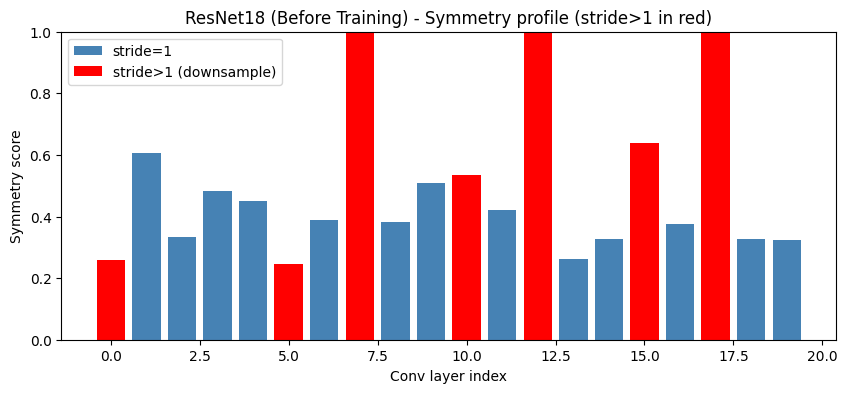

ResNet18 Epoch 1/2: 100%|█████████▉| 299/300 [01:56<00:00,  2.56it/s, acc=42.1, loss=1.35]


Epoch 1 finished | Avg Loss: 1.5631 | Acc: 42.10%


ResNet18 Epoch 2/2: 100%|█████████▉| 299/300 [01:58<00:00,  2.53it/s, acc=61.3, loss=1.25]


Epoch 2 finished | Avg Loss: 1.0774 | Acc: 61.28%
⏱ Total Training Time (ResNet18): 234.95 sec
Average symmetry AFTER training: 0.5572


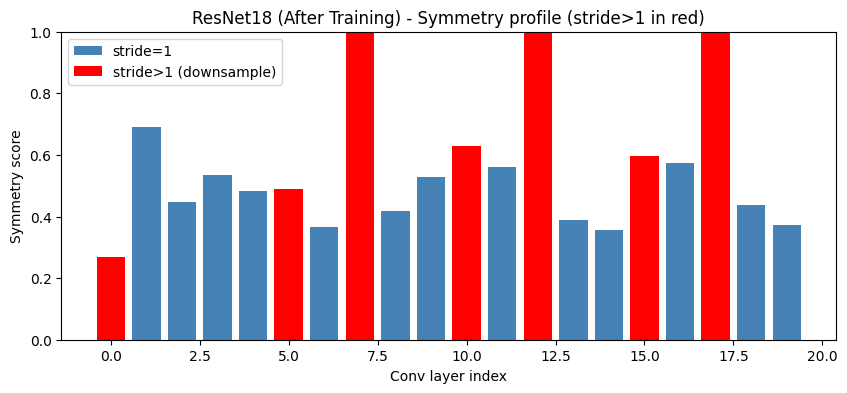

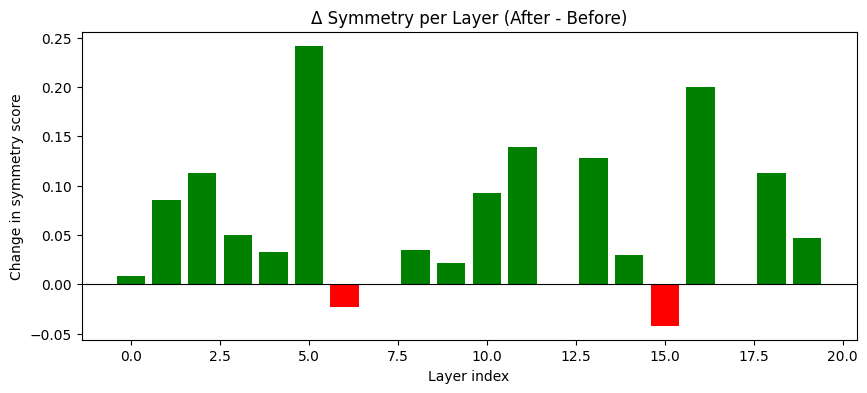


Average symmetry change (ResNet18): 0.0636
✅ Symmetry increased during training — matches paper’s observation!

===== PERFORMANCE SUMMARY (ResNet18) =====
MACs: 1.82 GMac, Params: 11.18 M
Training Time: 234.95s, Final Accuracy: 61.28%
Avg Symmetry Before: 0.4936, After: 0.5572

[VGG16] MACs: 15.52 GMac, Params: 134.3 M
Average symmetry BEFORE training (VGG16): 0.3992


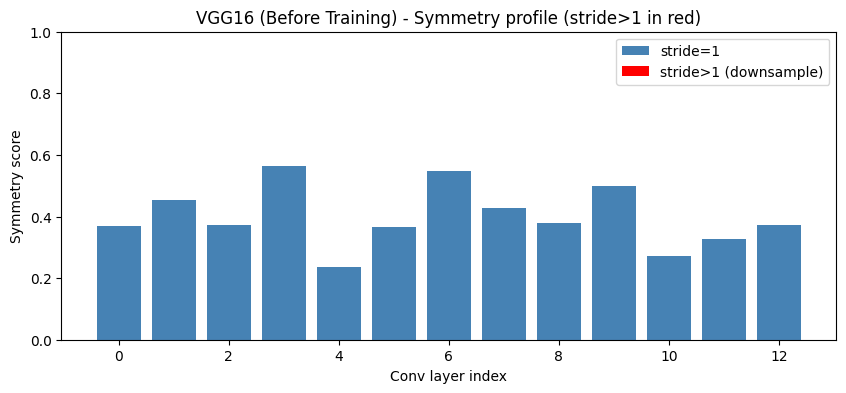

VGG16 Epoch 1/2: 100%|█████████▉| 299/300 [09:25<00:01,  1.89s/it, acc=23.9, loss=1.71]


Epoch 1 finished | Avg Loss: 2.0570 | Acc: 23.91%


VGG16 Epoch 2/2: 100%|█████████▉| 299/300 [09:24<00:01,  1.89s/it, acc=40.4, loss=1.43]


Epoch 2 finished | Avg Loss: 1.6308 | Acc: 40.37%
⏱ Total Training Time (VGG16): 1130.42 sec
Average symmetry AFTER training (VGG16): 0.6051


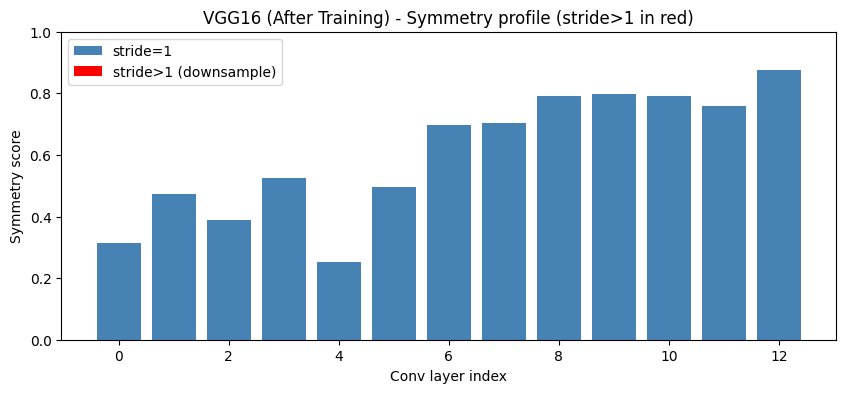

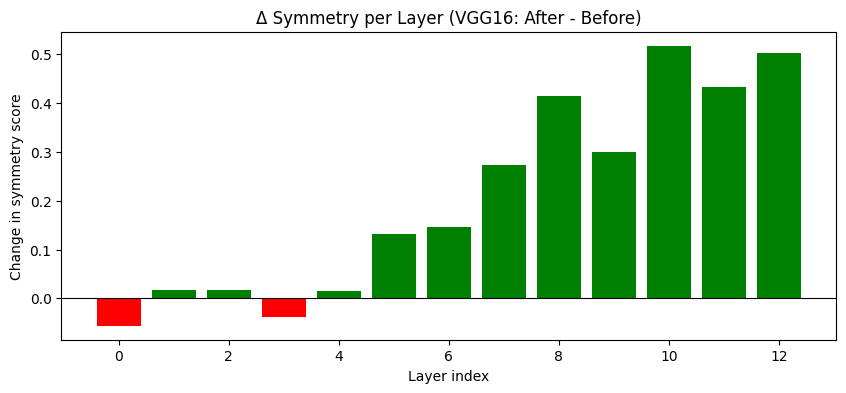


Average symmetry change (VGG16): 0.2059
✅ Symmetry increased during training — matches paper’s observation!

===== PERFORMANCE SUMMARY (VGG16) =====
MACs: 15.52 GMac, Params: 134.3 M
Training Time: 1130.42s, Final Accuracy: 40.37%
Avg Symmetry Before: 0.3992, After: 0.6051


In [ ]:
# --------------------------------------------
# Data: CIFAR-10 (resized to 224×224 for ResNet)
# --------------------------------------------
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor()
])
train_ds = CIFAR10(root='data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2)

# --------------------------------------------
# Model: ResNet18
# --------------------------------------------
model_resnet = torchvision.models.resnet18(pretrained=False, num_classes=10).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model_resnet.parameters(), lr=0.01, momentum=0.9)

# --- Hardware metrics before training ---
with torch.cuda.device(0):
    macs_resnet, params_resnet = get_model_complexity_info(model_resnet, (3, 224, 224),
                                                           as_strings=True, print_per_layer_stat=False)
print(f"\n[ResNet18] MACs: {macs_resnet}, Params: {params_resnet}")

# --------------------------------------------
# Measure symmetry before training
# --------------------------------------------
names_before, kernels_before, scores_before, strides_before = symmetry_profile_with_stride(model_resnet)
avg_before = np.mean(scores_before)
print("Average symmetry BEFORE training:", round(avg_before, 4))
plot_symmetry_bar_with_stride(names_before, scores_before, strides_before, "ResNet18 (Before Training)", top_n=40)

# --------------------------------------------
# Train for 2 epochs
# --------------------------------------------
target_acc = 70  # threshold accuracy for convergence tracking
converged_iter = None
start_time = time.time()

model_resnet.train()
for epoch in range(2):
    running_loss = 0.0
    correct, total = 0, 0
    pbar = tqdm(train_loader, total=300, desc=f"ResNet18 Epoch {epoch+1}/2")
    for i, (x, y) in enumerate(pbar):
        x, y = x.to(device), y.to(device)
        out = model_resnet(x)
        loss = criterion(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, pred = torch.max(out, 1)
        correct += (pred == y).sum().item()
        total += y.size(0)
        acc = 100 * correct / total
        pbar.set_postfix(loss=loss.item(), acc=acc)

        if acc >= target_acc and converged_iter is None:
            converged_iter = epoch * len(train_loader) + i  # record iteration count
        if i >= 299:
            break

    print(f"Epoch {epoch+1} finished | Avg Loss: {running_loss/300:.4f} | Acc: {acc:.2f}%")

end_time = time.time()
train_time = end_time - start_time
print(f"⏱ Total Training Time (ResNet18): {train_time:.2f} sec")
if converged_iter:
    print(f"⚡ Reached {target_acc}% accuracy after {converged_iter} iterations")

# --------------------------------------------
# Measure symmetry AFTER training
# --------------------------------------------
model_resnet.eval()
names_after, kernels_after, scores_after, strides_after = symmetry_profile_with_stride(model_resnet)
avg_after = np.mean(scores_after)
print("Average symmetry AFTER training:", round(avg_after, 4))
plot_symmetry_bar_with_stride(names_after, scores_after, strides_after, "ResNet18 (After Training)", top_n=40)

# --------------------------------------------
# Compare Before vs After
# --------------------------------------------
delta = np.array(scores_after) - np.array(scores_before)
plt.figure(figsize=(10,4))
plt.bar(range(len(delta)), delta, color=['green' if d > 0 else 'red' for d in delta])
plt.axhline(0, color='black', linewidth=0.8)
plt.title("Δ Symmetry per Layer (After - Before)")
plt.xlabel("Layer index")
plt.ylabel("Change in symmetry score")
plt.show()

print(f"\nAverage symmetry change (ResNet18): {avg_after - avg_before:.4f}")
if avg_after > avg_before:
    print("✅ Symmetry increased during training — matches paper’s observation!")
else:
    print("⚠️ Symmetry decreased or unchanged — may need more epochs.")

print("\n===== PERFORMANCE SUMMARY (ResNet18) =====")
print(f"MACs: {macs_resnet}, Params: {params_resnet}")
print(f"Training Time: {train_time:.2f}s, Final Accuracy: {acc:.2f}%")
if converged_iter:
    print(f"Iterations to {target_acc}%: {converged_iter}")
print(f"Avg Symmetry Before: {avg_before:.4f}, After: {avg_after:.4f}")

# ============================================
# VGG16: Symmetry Evolution + Performance
# ============================================

model_vgg = torchvision.models.vgg16(pretrained=False, num_classes=10).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model_vgg.parameters(), lr=0.01, momentum=0.9)

# --- Hardware metrics before training ---
with torch.cuda.device(0):
    macs_vgg, params_vgg = get_model_complexity_info(model_vgg, (3, 224, 224),
                                                     as_strings=True, print_per_layer_stat=False)
print(f"\n[VGG16] MACs: {macs_vgg}, Params: {params_vgg}")

# --------------------------------------------
# Measure symmetry before training
# --------------------------------------------
names_before_vgg, kernels_before_vgg, scores_before_vgg, strides_before_vgg = symmetry_profile_with_stride(model_vgg)
avg_before_vgg = np.mean(scores_before_vgg)
print("Average symmetry BEFORE training (VGG16):", round(avg_before_vgg, 4))
plot_symmetry_bar_with_stride(names_before_vgg, scores_before_vgg, strides_before_vgg, "VGG16 (Before Training)", top_n=40)

# --------------------------------------------
# Train for 2 epochs
# --------------------------------------------
target_acc = 70
converged_iter_vgg = None
start_time = time.time()

model_vgg.train()
for epoch in range(2):
    running_loss = 0.0
    correct, total = 0, 0
    pbar = tqdm(train_loader, total=300, desc=f"VGG16 Epoch {epoch+1}/2")
    for i, (x, y) in enumerate(pbar):
        x, y = x.to(device), y.to(device)
        out = model_vgg(x)
        loss = criterion(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, pred = torch.max(out, 1)
        correct += (pred == y).sum().item()
        total += y.size(0)
        acc = 100 * correct / total
        pbar.set_postfix(loss=loss.item(), acc=acc)

        if acc >= target_acc and converged_iter_vgg is None:
            converged_iter_vgg = epoch * len(train_loader) + i
        if i >= 299:
            break

    print(f"Epoch {epoch+1} finished | Avg Loss: {running_loss/300:.4f} | Acc: {acc:.2f}%")

end_time = time.time()
train_time_vgg = end_time - start_time
print(f"⏱ Total Training Time (VGG16): {train_time_vgg:.2f} sec")
if converged_iter_vgg:
    print(f"⚡ Reached {target_acc}% accuracy after {converged_iter_vgg} iterations")

# --------------------------------------------
# Measure symmetry AFTER training
# --------------------------------------------
model_vgg.eval()
names_after_vgg, kernels_after_vgg, scores_after_vgg, strides_after_vgg = symmetry_profile_with_stride(model_vgg)
avg_after_vgg = np.mean(scores_after_vgg)
print("Average symmetry AFTER training (VGG16):", round(avg_after_vgg, 4))
plot_symmetry_bar_with_stride(names_after_vgg, scores_after_vgg, strides_after_vgg, "VGG16 (After Training)", top_n=40)

# --------------------------------------------
# Compare Before vs After
# --------------------------------------------
delta_vgg = np.array(scores_after_vgg) - np.array(scores_before_vgg)
plt.figure(figsize=(10,4))
plt.bar(range(len(delta_vgg)), delta_vgg, color=['green' if d > 0 else 'red' for d in delta_vgg])
plt.axhline(0, color='black', linewidth=0.8)
plt.title("Δ Symmetry per Layer (VGG16: After - Before)")
plt.xlabel("Layer index")
plt.ylabel("Change in symmetry score")
plt.show()

print(f"\nAverage symmetry change (VGG16): {avg_after_vgg - avg_before_vgg:.4f}")
if avg_after_vgg > avg_before_vgg:
    print("✅ Symmetry increased during training — matches paper’s observation!")
else:
    print("⚠️ Symmetry decreased or unchanged — may need more epochs.")

print("\n===== PERFORMANCE SUMMARY (VGG16) =====")
print(f"MACs: {macs_vgg}, Params: {params_vgg}")
print(f"Training Time: {train_time_vgg:.2f}s, Final Accuracy: {acc:.2f}%")
if converged_iter_vgg:
    print(f"Iterations to {target_acc}%: {converged_iter_vgg}")
print(f"Avg Symmetry Before: {avg_before_vgg:.4f}, After: {avg_after_vgg:.4f}")
